In [ ]:
import os
import cv2
from ultralytics import SAM, FastSAM
import numpy as np
import torch

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load the model on GPU if available
model = FastSAM("FastSAM-s.pt").to(device)

# Perform inference with the model running on GPU
#results = model(source=image_path, device=device, stream=True)

# Display model information (optional)
model.info()

# Define thresholds for filtering bounding boxes
MAX_AREA_THRESHOLD = 8000  # Maximum area of a bounding box to consider
MIN_AREA_THRESHOLD = 300   # Minimum area of a bounding box to consider
MAX_ASPECT_RATIO = 2.0     # Maximum aspect ratio to consider a segment elongated
MIN_WHITE_INTENSITY = 125  # Minimum mean intensity to consider a blob "white"

# Path to the images directory
image_folder = '/home/ttyh/hot3d/hot3d/dataset/images'
output_folder = '/home/ttyh/hot3d/hot3d/dataset/cropped_objects'

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Process each image in the folder
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)

    # Run inference on the current frame to get bounding boxes
    results = model(source=image_path, stream=True)

    for r in results:
        masks = r.masks  # Get segmentation masks

        # Extract bounding boxes from masks
        for mask in masks.xy:
            # Convert the list of coordinates to a NumPy array (polygon format)
            mask_polygon = np.array(mask, dtype=np.int32).reshape((-1, 1, 2))

            # Fit a bounding rectangle to the mask and calculate aspect ratio and area
            x, y, w, h = cv2.boundingRect(mask_polygon)
            area = w * h  # Calculate bounding box area

            # Filter out unwanted bounding boxes based on area and aspect ratio
            if y < 75 or h == 0 or w == 0:
                continue
            aspect_ratio = max(w / h, h / w)

            if area > MAX_AREA_THRESHOLD or area < MIN_AREA_THRESHOLD:
                continue  # Skip this bounding box if it's too large or too small

            # Crop the detected object from the original image
            cropped_object = image[y:y+h, x:x+w]
            
            # Save the cropped object
            #cropped_filename = os.path.join(output_folder, f"cropped_{image_name}_{x}_{y}.jpg")
            #cv2.imwrite(cropped_filename, cropped_object)
            #print(f"Saved cropped object: {cropped_filename}")

            # Draw the bounding box on the original image (green color)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Display the image with bounding boxes
        cv2.imshow("Detected Objects", image)

        # Break if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()

# Now, you can process the cropped images with YOLO


Using device: cuda
YOLOv8s-seg summary: 261 layers, 11,790,483 parameters, 0 gradients, 42.7 GFLOPs

image 1/1 /home/ttyh/hot3d/hot3d/dataset/images/bowl.jpg: 480x640 38 objects, 44.1ms


In [17]:
import cv2
from ultralytics import YOLO
import os
model = YOLO("yolo11n.pt")
image_folder = '/home/ttyh/hot3d/hot3d/dataset/cropped_objects'
# Process each image in the folder
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    results = model(image)[0]
    for box in results.boxes:
        label = results.names[int(box.cls)]
        confidence = box.conf.item()
        bbox = box.xyxy.tolist()
        print(f"Detected in {image_name}: {label}, Confidence: {confidence:.2f}, BBox: {bbox}")



0: 608x640 1 cake, 246.4ms
Speed: 2.4ms preprocess, 246.4ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)
Detected in cropped_bowl.jpg_282_198.jpg: cake, Confidence: 0.78, BBox: [[0.17151831090450287, 2.0732829570770264, 74.72217559814453, 65.25249481201172]]

0: 608x640 1 cake, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)
Detected in cropped_bowl.jpg_478_182.jpg: cake, Confidence: 0.62, BBox: [[0.13836364448070526, 1.267905354499817, 66.3194808959961, 61.257545471191406]]

0: 352x640 1 apple, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)
Detected in cropped_bowl.jpg_374_170.jpg: apple, Confidence: 0.50, BBox: [[0.8169276118278503, 0.5461934208869934, 82.26480102539062, 41.80857849121094]]

0: 640x640 1 banana, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Detected in cropped_bowl.jpg_314_234.jpg: ba

In [6]:
import cv2
from ultralytics import YOLO
import os
model = YOLO("yolo11n.pt")
image_folder = '/home/ttyh/hot3d/hot3d/dataset/images'
# Process each image in the folder
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    results = model(image)[0]
    for box in results.boxes:
        label = results.names[int(box.cls)]
        confidence = box.conf.item()
        bbox = box.xyxy.tolist()
        print(f"Detected in {image_name}: {label}, Confidence: {confidence:.2f}, BBox: {bbox}")



0: 480x640 1 bowl, 1 donut, 38.4ms
Speed: 1.6ms preprocess, 38.4ms inference, 19.7ms postprocess per image at shape (1, 3, 480, 640)
Detected in bowl.jpg: bowl, Confidence: 0.83, BBox: [[265.8050842285156, 74.77810668945312, 389.0524597167969, 172.14791870117188]]
Detected in bowl.jpg: donut, Confidence: 0.69, BBox: [[282.74169921875, 197.87307739257812, 357.4764404296875, 262.88568115234375]]

0: 480x640 1 cup, 1 hot dog, 1 donut, 1 cell phone, 6.5ms
Speed: 1.1ms preprocess, 6.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)
Detected in bread.jpg: hot dog, Confidence: 0.49, BBox: [[324.9237060546875, 241.66587829589844, 559.75341796875, 365.847412109375]]
Detected in bread.jpg: cup, Confidence: 0.39, BBox: [[436.44183349609375, 0.0419769287109375, 547.627197265625, 157.53321838378906]]
Detected in bread.jpg: donut, Confidence: 0.35, BBox: [[274.4947509765625, 205.23507690429688, 350.37939453125, 271.52032470703125]]
Detected in bread.jpg: cell phone, Confidence: 0

In [3]:
import torch
from PIL import Image
import os
from transformers import AutoProcessor, AutoModelForVision2Seq, AutoModelForCausalLM

DEVICE = "cuda" if torch.cuda.is_available() else "CPU"

model_id = "microsoft/Phi-3.5-vision-instruct" 

# Note: set _attn_implementation='eager' if you don't have flash_attn installed
model = AutoModelForCausalLM.from_pretrained(
  model_id, 
  device_map="cuda", 
  trust_remote_code=True, 
  torch_dtype="auto", 
  _attn_implementation='flash_attention_2'    
)

# for best performance, use num_crops=4 for multi-frame, num_crops=16 for single-frame.
processor = AutoProcessor.from_pretrained(model_id, 
  trust_remote_code=True, 
  num_crops=4
) 
messages = [
    {"role": "user", "content": "<|image_1|>\n List the objects in this picture"},
]

prompt = processor.tokenizer.apply_chat_template(
  messages, 
  tokenize=False, 
  add_generation_prompt=True
)

directory = '/home/ttyh/hot3d/hot3d/dataset/images'
for file in os.listdir(directory):
    image_path = os.path.join(directory, file)
    img = Image.open(image_path)
    inputs = processor(prompt, img, return_tensors="pt").to("cuda:0") 
    
    generation_args = { 
        "max_new_tokens": 1000, 
        "temperature": 0.0, 
        "do_sample": False, 
    } 
    
    generate_ids = model.generate(**inputs, 
      eos_token_id=processor.tokenizer.eos_token_id, 
      **generation_args
    )
    
    # remove input tokens 
    generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
    response = processor.batch_decode(generate_ids, 
      skip_special_tokens=True, 
      clean_up_tokenization_spaces=False)[0] 
    
    print(image_path, ':', response)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ttyh/hot3d/hot3d/dataset/images/bowl.jpg : In the image, there are several objects on a table. These include a bowl, a black cutting mat, a piece of bread, a piece of cake, a piece of fruit, and a piece of meat.
/home/ttyh/hot3d/hot3d/dataset/images/bread.jpg : In the image, there are several objects:

1. A machine with a black base and a silver top, possibly a 3D printer or a machine for creating objects.
2. A black cutting mat with white grid lines, used for cutting or guiding the placement of objects.
3. A black tray with a grid pattern, which is likely used to hold objects in place during the printing or cutting process.
4. A white plate, which might be used to hold or display the objects after they are created.
5. A white object that appears to be a piece of paper or a label, placed on the cutting mat.
6. A white object that looks like a piece of fruit, possibly a banana or a similar item, placed on the cutting mat.
7. A white object that resembles a piece of bread or a roll

In [4]:
import torch
from PIL import Image
import os
from transformers import AutoProcessor, AutoModelForVision2Seq, AutoModelForCausalLM

DEVICE = "cuda" if torch.cuda.is_available() else "CPU"

model_id = "microsoft/Phi-3.5-vision-instruct" 

# Note: set _attn_implementation='eager' if you don't have flash_attn installed
model = AutoModelForCausalLM.from_pretrained(
  model_id, 
  device_map="cuda", 
  trust_remote_code=True, 
  torch_dtype="auto", 
  _attn_implementation='flash_attention_2'    
)

# for best performance, use num_crops=4 for multi-frame, num_crops=16 for single-frame.
processor = AutoProcessor.from_pretrained(model_id, 
  trust_remote_code=True, 
  num_crops=4
) 
messages = [
    {"role": "user", "content": "<|image_1|>\n List the objects in this picture, especially those in the bounding boxes."},
]

prompt = processor.tokenizer.apply_chat_template(
  messages, 
  tokenize=False, 
  add_generation_prompt=True
)

directory = '/home/ttyh/hot3d/hot3d/dataset/box'
for file in os.listdir(directory):
    image_path = os.path.join(directory, file)
    img = Image.open(image_path)
    inputs = processor(prompt, img, return_tensors="pt").to("cuda:0") 
    
    generation_args = { 
        "max_new_tokens": 1000, 
        "temperature": 0.0, 
        "do_sample": False, 
    } 
    
    generate_ids = model.generate(**inputs, 
      eos_token_id=processor.tokenizer.eos_token_id, 
      **generation_args
    )
    
    # remove input tokens 
    generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
    response = processor.batch_decode(generate_ids, 
      skip_special_tokens=True, 
      clean_up_tokenization_spaces=False)[0] 
    
    print(image_path, ':', response)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ttyh/hot3d/hot3d/dataset/box/fast_sambowl.jpg.jpg : In the image, there are several objects that can be identified. Starting from the left, there is a white bowl on a black mat. Next to the bowl, there is a white container with a black lid, which appears to be a blender or a mixer. In the center of the image, there is a large, elongated object that resembles a hot dog or a sausage. To the right of the hot dog, there is a smaller, round object that could be a donut or a pastry. The background is less clear, but it seems to be a kitchen or a workspace with various items and equipment.
/home/ttyh/hot3d/hot3d/dataset/box/fast_sambread.jpg.jpg : The image shows a laboratory setting with various objects. There are two objects that resemble donuts, one on the left side of the image and another on the right side. There is also a long, orange object that could be a piece of food or a test tube, located in the center of the image. Additionally, there are green boxes with white outlines, po


KeyboardInterrupt



In [ ]:
import cv2
from ultralytics import YOLO

# Load the YOLO model (ensure you have the model downloaded)
model = YOLO("yolov8n-seg.pt")  # Use a segmentation model

# Read the image
image_path = '/home/ttyh/hot3d/hot3d/dataset/images/bread.jpg'
img = cv2.imread(image_path)

# Perform segmentation
results = model(image_path)

# Draw segmentation masks and bounding boxes
for result in results:
    masks = result.masks.xy  # Get segmentation masks
    for mask in masks:
        mask = mask.astype(int)
        cv2.polylines(img, [mask], isClosed=True, color=(0, 255, 0), thickness=2)

# Display segmented image
cv2.imshow("Segmented Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()



image 1/1 /home/ttyh/hot3d/hot3d/dataset/images/bread.jpg: 480x640 1 cup, 1 banana, 1 hot dog, 3 donuts, 1 dining table, 42.4ms
Speed: 5.7ms preprocess, 42.4ms inference, 110.6ms postprocess per image at shape (1, 3, 480, 640)


100%|██████████| 5.35M/5.35M [00:00<00:00, 109MB/s]



0: 480x640 1 bowl, 1 donut, 48.2ms
Speed: 26.0ms preprocess, 48.2ms inference, 133.8ms postprocess per image at shape (1, 3, 480, 640)


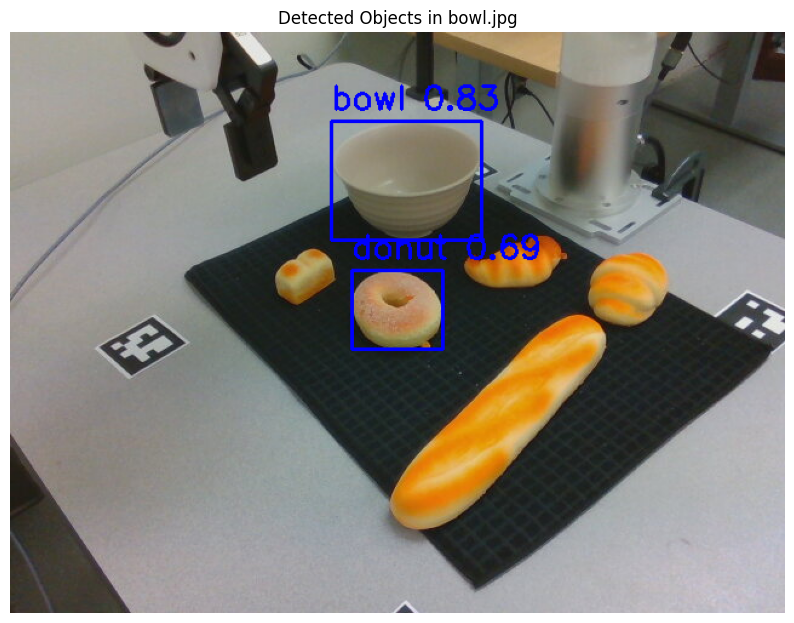

Processed and displayed bowl.jpg

0: 480x640 1 cup, 1 hot dog, 1 donut, 1 cell phone, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 12.2ms postprocess per image at shape (1, 3, 480, 640)


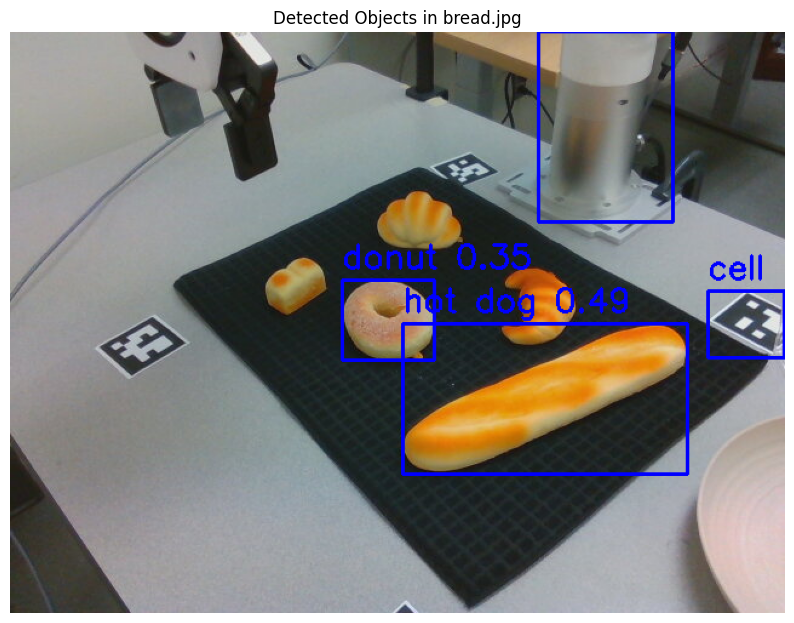

Processed and displayed bread.jpg

0: 480x640 3 cups, 1 keyboard, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 12.3ms postprocess per image at shape (1, 3, 480, 640)


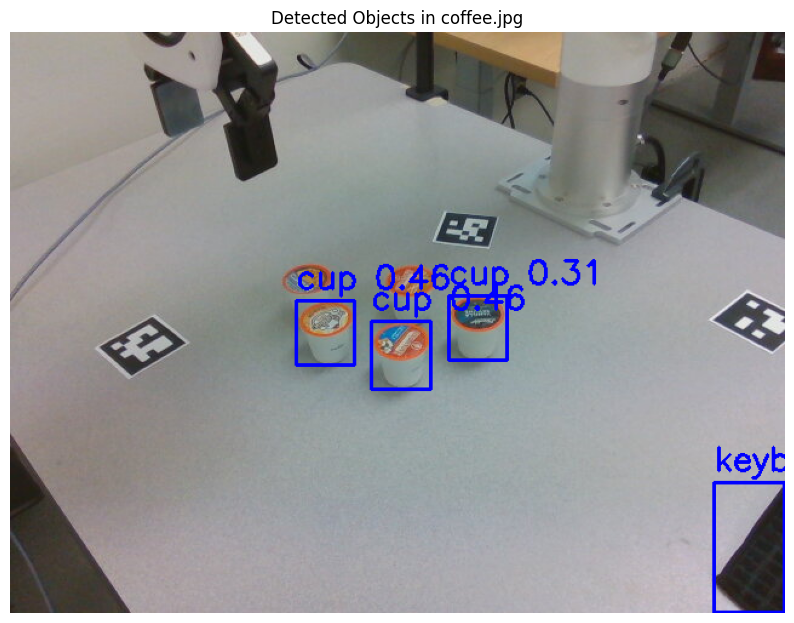

Processed and displayed coffee.jpg

0: 480x640 2 cups, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 11.9ms postprocess per image at shape (1, 3, 480, 640)


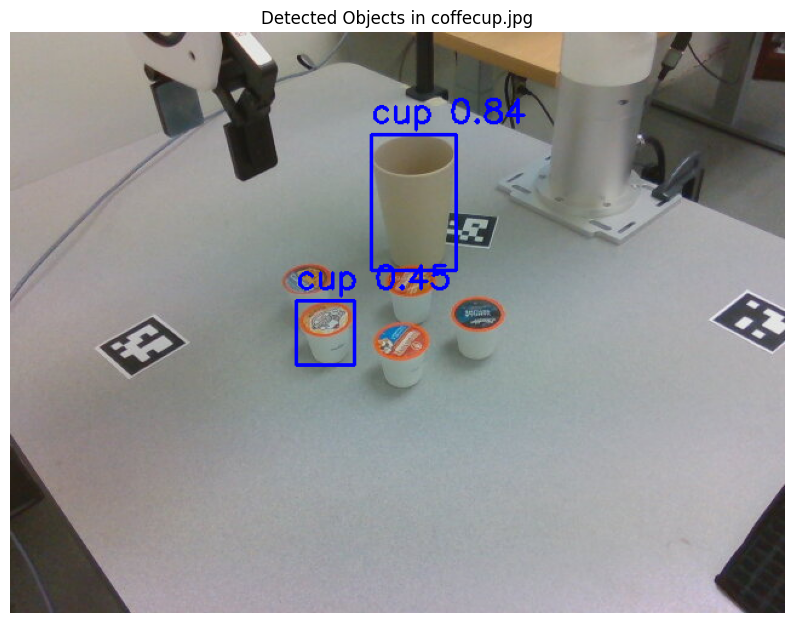

Processed and displayed coffecup.jpg

0: 480x640 1 sink, 8.4ms
Speed: 1.1ms preprocess, 8.4ms inference, 12.2ms postprocess per image at shape (1, 3, 480, 640)


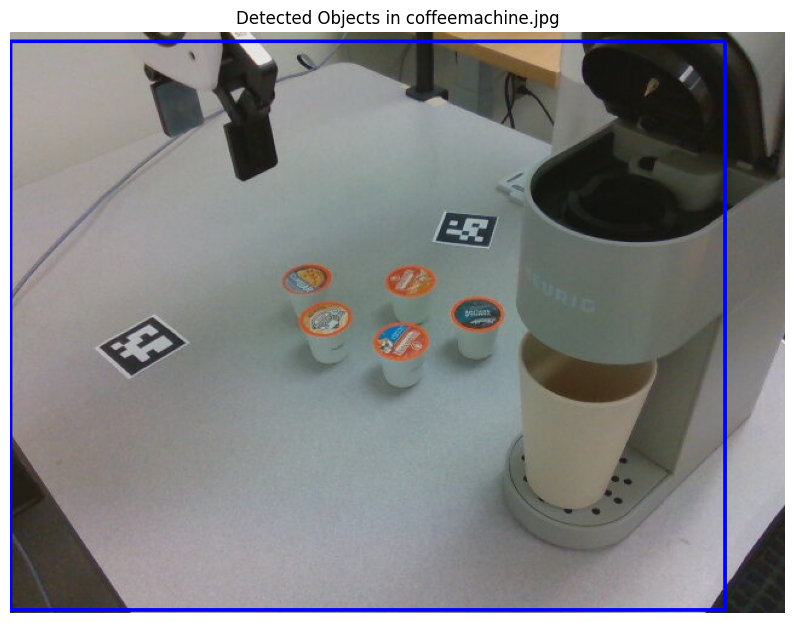

Processed and displayed coffeemachine.jpg

0: 480x640 1 bowl, 2 donuts, 1 dining table, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 8.8ms postprocess per image at shape (1, 3, 480, 640)


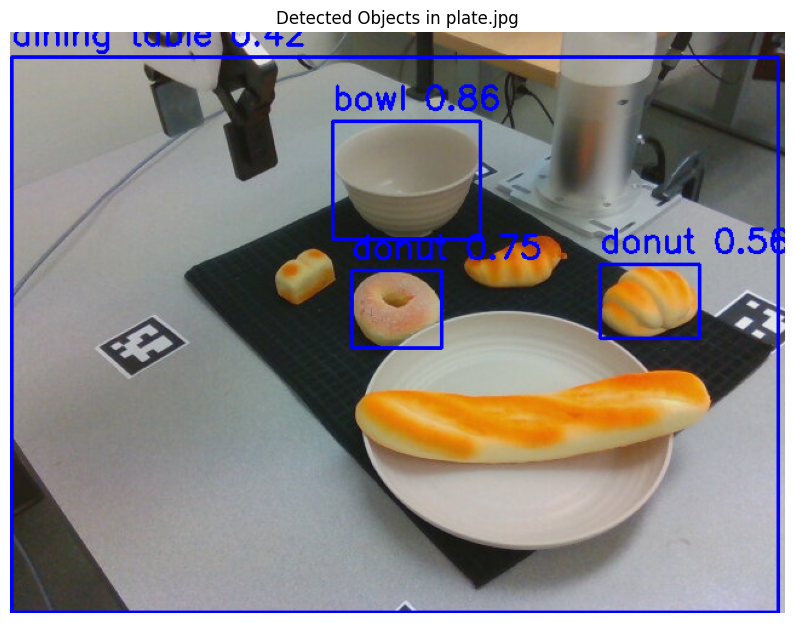

Processed and displayed plate.jpg
All images processed and displayed with bounding boxes.


In [8]:
import cv2
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt

model = YOLO("yolo11n.pt")
image_folder = '/home/ttyh/hot3d/hot3d/dataset/images'

# Process each image in the folder
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    results = model(image)[0]
    for box in results.boxes:
        label = results.names[int(box.cls)]
        confidence = box.conf.item()
        bbox = box.xyxy.tolist()[0]
        # Draw the bounding box
        cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
        # Put the label and confidence
        cv2.putText(image, f"{label} {confidence:.2f}", (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    # Convert BGR image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(f"Detected Objects in {image_name}")
    plt.axis('off')
    plt.show()
    print(f"Processed and displayed {image_name}")

print("All images processed and displayed with bounding boxes.")


In [7]:
!pip install ultralytics

  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 36.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 62.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 98.6 MB/s eta 0:00:00:00:010:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached ultralytics_thop-2.0.14-py3-none-any.whl (26 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 102.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Fou